# PointNet for particle flow

This notebook repeats the full demo of a data analysis pipeline, but with a more solid approach introducing some MLOps best practice. 

<div class="alert alert-block alert-info">

**Main changes:** 

- move all function definitions we are going to re-use to python modules, which are only imported in analysis notebook
- move hyperparameters and settings to the top, so that they are easy to find and change
- introduce basic logging to Weights & Biases to keep track of experiments configuration and results

</div>

## Problem

This dataset contains a Monte Carlo simulation of $\rho^{\pm} \rightarrow \pi^{\pm} + \pi^0$ decays and the corresponding detector response. Specifically, the data report the measured response of **i) tracker** and **ii) calorimeter**, along with the true pyshical quantitites that generated those measurements.

<div class="alert alert-block alert-info">
This means that we expect one track per event, with mainly two energy blobs (clusters of cells) in the calorimeter.
</div>

The final **goal** is to associate the cell signals observed in the calorimeter to the track that caused those energy deposits.

## Method

The idea is to leverage a **point cloud** data representation to combine tracker and calorimeter information so to associate cell hits to the corresponding track. We will use a [**PointNet**](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf) model that is capable of handling this type of data, framed as a **semantic segmentation** approach. More precisely, this means that:
- we represent each hit in the detector as a point in the point cloud: x, y, z coordinates + additional features ("3+"-dimensional point)
- the **learning task** will be binary classification at hit level: for each cell the model learns whether its energy comes mostly from the track (class 1) or not (class 0)

## Data structure

<div class="alert alert-block alert-info">

This dataset is organized as follows:
 - for each event, we create a **sample** (i.e. point cloud)
 - each sample contains all hits in a cone around a track of the event, called **focal track**
     - the cone includes all hits within some $\Delta R$ distance of the track
     - if an event has multiple tracks, then we have more samples per event
     - since different samples have possibly different number of hits, **we pad all point clouds to ensure they have same size** (needed since the model requires inputs of same size)

</div>

## Settings & config

This section collects all configuration variables and training/model hyperparameters. 

The idea is to put it at the top so that it is easy to find and edit.

In [1]:
import sys
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

REPO_BASEPATH = Path().cwd().parent
DATA_PATH = REPO_BASEPATH / "pnet_data/raw/rho_small.npz"
CODE_PATH = REPO_BASEPATH / "src"
sys.path.append(str(CODE_PATH))

from data_viz import event_id_to_sample_id, get_logbins, plot_point_cloud, plot_histograms, plot_result, visualize_prediction


LABELS = ["unfocus hit", "focus hit"]

## Exploratory Data Analysis (EDA)

In [2]:
# load data
events = np.load(DATA_PATH)["feats"]

In [3]:
### dataset content and types

# n_samples and points_per_sample
print("Data format and shape:")
print(f"{type(events)}\t{events.shape=}\n\n")
# Note: structured numpy array --> columns accessible by name

# dataset columns
print(f"Column\tdtype")
for colname, coltype in events.dtype.descr:
    print(f"{colname}\t:{coltype}")

Data format and shape:
<class 'numpy.ndarray'>	events.shape=(325, 800)


Column	dtype
event_number	:<i4
cell_ID	:<i4
track_ID	:<i4
delta_R	:<f4
truth_cell_focal_fraction_energy	:<f4
truth_cell_non_focal_fraction_energy	:<f4
truth_cell_neutral_fraction_energy	:<f4
truth_cell_total_energy	:<f4
category	:|i1
track_num	:<i4
x	:<f4
y	:<f4
z	:<f4
distance	:<f4
normalized_x	:<f4
normalized_y	:<f4
normalized_z	:<f4
normalized_distance	:<f4
cell_sigma	:<f4
track_chi2_dof	:<f4
track_chi2_dof_cell_sigma	:<f4
cell_E	:<f4
normalized_cell_E	:<f4
track_pt	:<f4
normalized_track_pt	:<f4
track_pt_cell_E	:<f4
normalized_track_pt_cell_E	:<f4


In [4]:
# dataset statistics

n_samples, n_points_per_sample = events.shape

sample_event_ids = events['event_number'][:,0]
event_ids, event_ids_count = np.unique(sample_event_ids, return_counts=True)
n_events = len(event_ids)

print(f"{n_events=}")
print(f"{n_samples=}")
print(f"{n_points_per_sample=}")

n_events=314
n_samples=325
n_points_per_sample=800


In [5]:
# take one point per sample and check event_number; 
# if event_number is repeated it means we have more samples per that event_number
# we take just one point, since event_number repeated for each point otherwise
n_samples_per_event = np.unique(events['event_number'][:, 0], return_counts=True)

multiple_samples_event_ids = n_samples_per_event[0][n_samples_per_event[1]>1]
print("This events unexpectedly have more than one sample per event... --> TO CHECK")
multiple_samples_event_ids

This events unexpectedly have more than one sample per event... --> TO CHECK


array([826871, 827140, 827188, 827226, 827242, 828437], dtype=int32)

### Number of tracks and cells per event/sample

In [6]:
for _ in events.dtype.names:
    print(_)

event_number
cell_ID
track_ID
delta_R
truth_cell_focal_fraction_energy
truth_cell_non_focal_fraction_energy
truth_cell_neutral_fraction_energy
truth_cell_total_energy
category
track_num
x
y
z
distance
normalized_x
normalized_y
normalized_z
normalized_distance
cell_sigma
track_chi2_dof
track_chi2_dof_cell_sigma
cell_E
normalized_cell_E
track_pt
normalized_track_pt
track_pt_cell_E
normalized_track_pt_cell_E


#### tracks 

In [7]:
import pandas as pd

events_df = pd.DataFrame(events.reshape(-1).T, columns=events.dtype.names)
sample_id_col = np.repeat(np.arange(events.shape[0]), events.shape[1])
events_df['sample_ID'] = sample_id_col

n_tracks_per_sample = events_df.groupby('sample_ID')['track_ID'].max() + 1
np.unique(n_tracks_per_sample, return_counts=True)

(array([1, 2, 3], dtype=int32), array([307,   3,  15]))

In [8]:
n_tracks_per_event = events_df.groupby('event_number')['track_ID'].max() + 1
np.unique(n_tracks_per_event, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([  1, 307,   2,   5]))

#### cells 

In [9]:
n_cells_per_sample = events_df[events_df['cell_ID'] != -1].groupby('sample_ID')['cell_ID'].count()
np.unique(n_cells_per_sample, return_counts=True)

(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  37,  38,
         39,  40,  41,  42,  45,  46,  47,  48,  49,  51,  53,  56,  61,
         65,  67,  69,  71,  72,  73,  74,  76,  77,  79,  80,  81,  82,
         84,  87,  88,  89,  90,  91,  92,  95,  98, 100, 101, 107, 108,
        109, 110, 111, 112, 113, 118, 119, 120, 122, 123, 125, 126, 127,
        130, 131, 133, 135, 136, 137, 139, 141, 142, 143, 144, 145, 146,
        148, 149, 150, 153, 154, 155, 156, 157, 158, 159, 161, 162, 164,
        165, 166, 170, 174, 176, 177, 178, 181, 182, 184, 185, 186, 187,
        189, 190, 191, 194, 195, 196, 197, 198, 199, 201, 202, 208, 209,
        213, 216, 217, 218, 219, 221, 224, 225, 229, 230, 231, 233, 234,
        235, 236, 237, 239, 240, 242, 246, 247, 248, 249, 250, 251, 252,
        253, 254, 255, 256, 258, 259, 260, 262, 263, 264, 265, 268, 270,
        271, 276, 277, 278, 280, 289, 291, 293, 296, 298, 299, 300, 301,
        310, 314, 320, 323, 330, 331, 334, 338, 339

In [10]:
n_cells_per_event =  events_df[events_df['cell_ID'] != -1].groupby('event_number')['cell_ID'].count()
np.unique(n_cells_per_event, return_counts=True)

(array([  25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          37,   38,   39,   40,   41,   42,   45,   46,   47,   48,   49,
          51,   53,   56,   61,   65,   67,   69,   71,   72,   73,   74,
          76,   77,   79,   80,   81,   82,   84,   87,   88,   89,   90,
          91,   92,   95,   98,  100,  101,  107,  108,  109,  110,  111,
         112,  113,  118,  120,  122,  123,  125,  126,  127,  130,  131,
         133,  135,  136,  137,  139,  141,  142,  143,  144,  145,  146,
         148,  149,  150,  153,  154,  155,  156,  157,  158,  159,  161,
         162,  164,  165,  166,  170,  174,  176,  177,  178,  181,  182,
         184,  185,  186,  187,  189,  190,  191,  194,  195,  196,  197,
         198,  199,  201,  202,  208,  209,  213,  216,  218,  219,  221,
         224,  225,  229,  230,  233,  234,  235,  236,  237,  239,  240,
         242,  246,  247,  248,  249,  250,  251,  252,  254,  255,  256,
         258,  259,  260,  262,  263, 

### Visualizations

/tmp/ipykernel_3009/387582596.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)


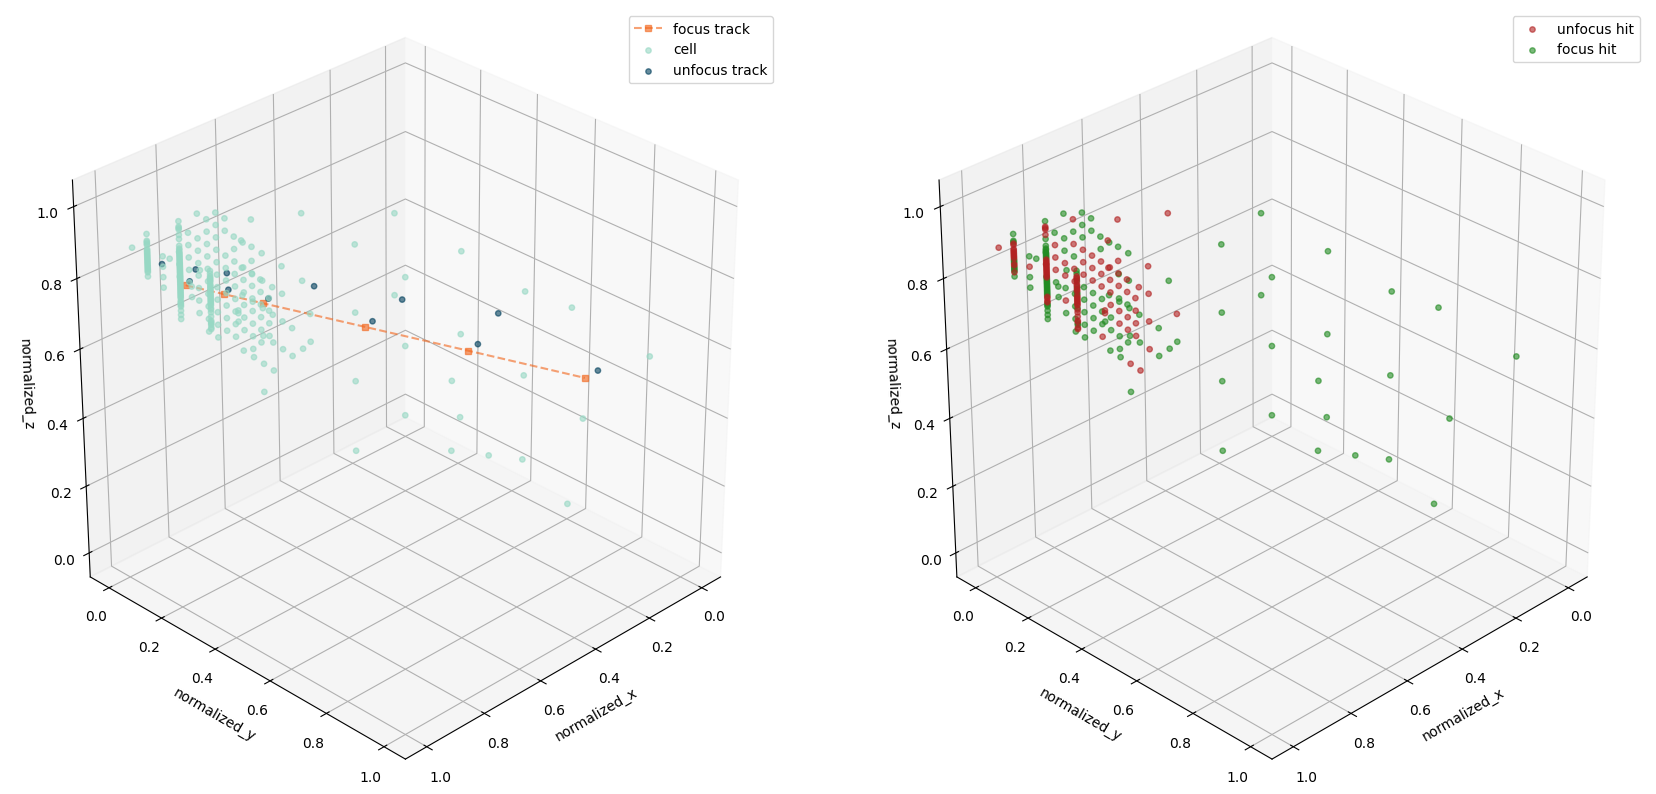

In [11]:
hit_type = {
    # -1: 'padding',
    0: 'focus track',
    1: 'cell',
    2: 'unfocus track'
}
hit_colors = {
    -1: '#4059AD',  # Royal Blue
    0: '#F26419',   # Burnt Orange,
    1: '#97D8C4',   # Mint
    2: '#003F5C',   # Sky Blue
}

class_type = {
    -1: 'unfocus hit',
    1: 'focus hit',
}

class_colors = {-1: 'firebrick', 1: 'forestgreen',}

sample_id = event_id_to_sample_id(events_df, multiple_samples_event_ids[1])[0]
sample_df = events_df.query('sample_ID == @sample_id & category != -1')
sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)

fig = plt.figure(figsize=(20, 8))  # Double the width compared to single plot
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first plot
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second plot

panel_left = plot_point_cloud(
    sample_df, fig=fig, ax=ax1,
    x_col='normalized_x', y_col='normalized_y', z_col='normalized_z',
    category_labels=hit_type,
    view_angle=(30, 45),
    point_size=15,
    color_map=hit_colors
)
panel_right = plot_point_cloud(
    sample_df.query('category == 1'), fig=fig, ax=ax2,
    x_col='normalized_x', y_col='normalized_y', z_col='normalized_z',
    category_col='target_class', category_labels=class_type,
    view_angle=(30, 45),
    point_size=15,
    color_map=class_colors
)

plt.show()

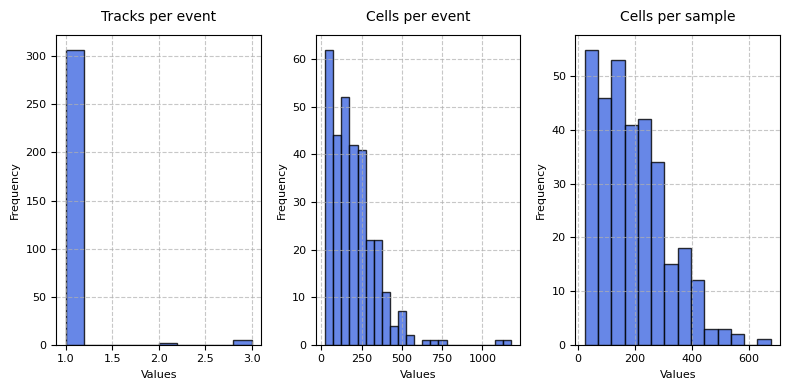

In [12]:
data_dict = {
    'Tracks per event': n_tracks_per_event[1:],
    #'Tracks per sample': n_tracks_per_sample,
    'Cells per event': n_cells_per_event,
    'Cells per sample': n_cells_per_sample
}

# Create plot
fig = plot_histograms(data_dict, figsize=(8,4), bins='auto', density=False)
plt.show()

### Feature distributions

Here we inspect the distribution of important features to use during training:
 - cell_E: energy measured in calorimeter cells
 - track_pt: momentum measured in the tracker (analogous of energy for track hits)
 - category: type of hit
     - focus track (0)
     - calo cell (1)
     - unfocus track (2)
     - padding (-1)

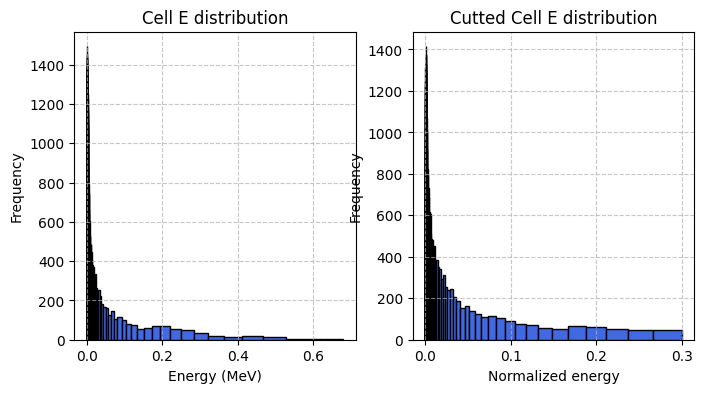

In [13]:
cell_E = events_df.query("category in [1]").normalized_cell_E

n_bins = 100
bins = get_logbins(cell_E, n_bins)

fig, axes = plt.subplots(1, 2, figsize=(8,4))

cell_E.hist(bins=bins, color='royalblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Cell E distribution')
axes[0].set_xlabel('Energy (MeV)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, axis='both', linestyle='--', alpha=0.7)

# cutted distribution
cutted_cell_E = cell_E[cell_E < 0.3] # 300 on original scale
bins = get_logbins(cutted_cell_E, n_bins)
cutted_cell_E.hist(bins=bins, color='royalblue', edgecolor='black', ax=axes[1])
plt.title('Cutted Cell E distribution')
plt.xlabel('Normalized energy')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

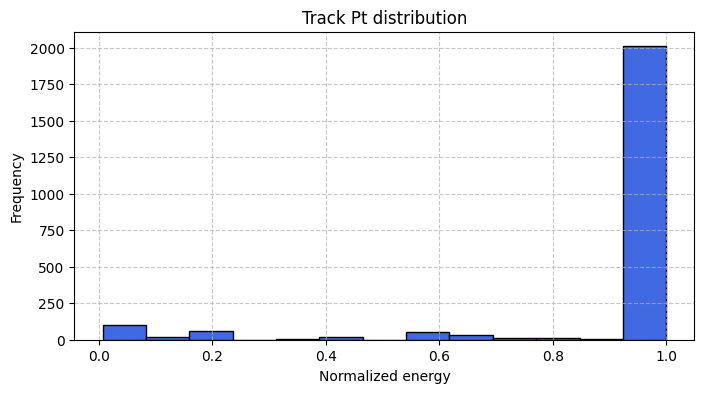

In [14]:
events_df.query("category in [0, 2]").normalized_track_pt.hist(bins='auto', figsize=(8, 4), 
                                                    color='royalblue', edgecolor='black',
                                                    #grid=dict(axis='both', linestyle='--', alpha=0.7)
                                                   )

plt.title('Track Pt distribution')
plt.xlabel('Normalized energy')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

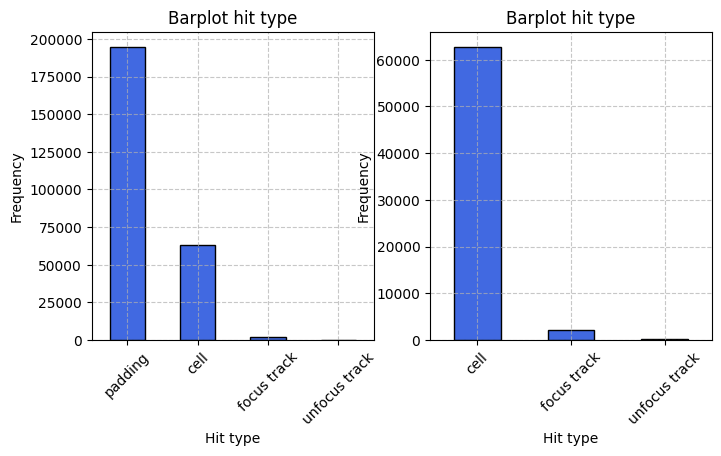

In [15]:
label_map = {
    -1: 'padding',
    0: 'focus track',
    1: 'cell',
    2: 'unfocus track'
}

fig, axes = plt.subplots(1, 2, figsize=(8,4))

events_df.category.map(label_map).value_counts().plot(
    kind='bar', color='royalblue', edgecolor='black', rot=45, ax=axes[0])
axes[0].set_title('Barplot hit type')
axes[0].set_xlabel('Hit type')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, axis='both', linestyle='--', alpha=0.7)

# cutted distribution
events_df.query('category != -1').category.map(label_map).value_counts().plot(
    kind='bar', color='royalblue', edgecolor='black', rot=45, ax=axes[1])
plt.title('Barplot hit type')
plt.xlabel('Hit type')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

### Target distribution

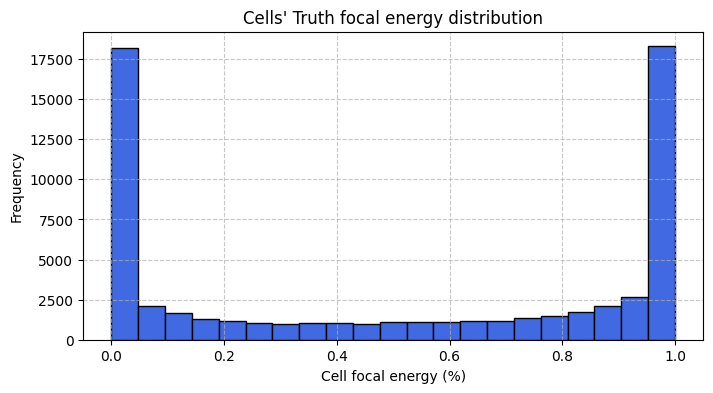

In [16]:
sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)



events_df.query("category == 1").truth_cell_focal_fraction_energy.hist(bins='auto', figsize=(8, 4), 
                                                    color='royalblue', edgecolor='black',
                                                    #grid=dict(axis='both', linestyle='--', alpha=0.7)
                                                   )
plt.title("Cells' Truth focal energy distribution")
plt.xlabel('Cell focal energy (%)')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

## Model training

We proceed with model training:

1. split the data
1. build our PointNet model using Tensorflow/Keras
1. create a dataloader to feed batches into our model
1. train
1. check results

### Data splitting

We choose 65%, 20%, 15% fractions for training, validation and testing data, respectively.

In [18]:
# set random seed for reproducibility
np.random.seed(18) 

N_TRAIN, N_VAL, N_TEST = 210, 65, 50 # roughly 0.65, 0.2, 0.15

all_idx = [*range(events.shape[0])]

train_idx = np.random.choice(all_idx, N_TRAIN, replace=False)
remaining_idx = np.array(list(set(all_idx).difference(train_idx)))
val_idx = np.random.choice(remaining_idx, N_VAL, replace=False)
test_idx = np.array(set(remaining_idx).difference(val_idx))

### PointNet model 

We use a PointNet model for semantic segmentation. Here is an illustration of its structure:

![PointNet architecture](../pnet_data/images/pointnet-architecture.jpg)

We have two heads:
 - classification head (used for point cloud classification)
 - segmentation head (used for semantic segmentation)

We are going to use the **segmentation head** for our problem. The architecture settings we can experiment with are:
 - `n_features` (the number of input features): original version has only size 3 as it only takes x,y,z coordinates
 - `init_size` (number of filters of first convolutional layer): original version has 64
 - `end_size` (number of filters in segmentation head): original version has 128

In [19]:
import tensorflow as tf 
import keras
from keras import layers


N_FEATURES = 3
INIT_SIZE = 8
END_SIZE = 16

def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

def transformation_net(inputs, num_features, name):
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=INIT_SIZE, name=f"{name}_1")
    x = conv_block(x, filters=INIT_SIZE*2, name=f"{name}_2")
    x = conv_block(x, filters=INIT_SIZE*32, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=INIT_SIZE*8, name=f"{name}_1_1")
    x = mlp_block(x, filters=INIT_SIZE*4, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

def get_shape_segmentation_model(num_points, num_classes, n_features, init_size, end_size):
    input_points = keras.Input(shape=(None, n_features))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=n_features, name="input_transformation_block"
    )
    features_init = conv_block(transformed_inputs, filters=init_size, name=f"features_{init_size}")
    features_2x_1 = conv_block(features_init, filters=init_size*2, name=f"features_{init_size*2}_1")
    features_2x_2 = conv_block(features_2x_1, filters=init_size*2, name=f"features_{init_size*2}_2")
    transformed_features = transformation_block(
        features_2x_2, num_features=init_size*2, name="transformed_features"
    )
    features_8x = conv_block(transformed_features, filters=init_size*8, name=f"features_{init_size*8}")
    features_32x = conv_block(features_8x, filters=init_size*32, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_32x
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_init,
            features_2x_1,
            features_2x_2,
            transformed_features,
            features_8x,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=end_size, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)


2024-11-24 12:28:52.729843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 12:28:54.203924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Tensorflow datasets

In [20]:
# used as dataloader
from numpy.lib.recfunctions import structured_to_unstructured

NUM_SAMPLE_POINTS = events.shape[1]
LABELS = ["unfocus hit", "focus hit"]
BATCH_SIZE = 16

def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, N_FEATURES])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS)])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(point_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    # print(point_cloud_batch.shape, noise.shape, label_cloud_batch.shape)

    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    # reformat to unstructured array and transform to list of size n_samples, each element of size n_ponints x n_features
    point_clouds = structured_to_unstructured(point_clouds).astype(np.float64)
    point_clouds = [_ for _ in point_clouds]
    
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


input_features = ["normalized_x", "normalized_y", "normalized_z"]
target_class = [(energy_fraction > 0.5).astype(np.float32) for energy_fraction in events['truth_cell_focal_fraction_energy']]
# target_class = (events["truth_cell_focal_fraction_energy"] > 0.5).reshape(-1)
target_class = keras.utils.to_categorical(target_class, num_classes=len(LABELS))

train_point_clouds = events[input_features][train_idx, :]
train_label_cloud = target_class[train_idx, :]
total_training_examples = len(train_point_clouds)

val_point_clouds = events[input_features][val_idx, :]
val_label_cloud = target_class[val_idx, :]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 210
Num train point cloud labels: 210
Num val point clouds: 65
Num val point cloud labels: 65
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 800, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 800, 2), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 800, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 800, 2), dtype=tf.float64, name=None))>


2024-11-24 12:28:56.467366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 12:28:56.514756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 12:28:56.516854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Training 

In [21]:
NUM_POINTS = 800
NUM_CLASSES = len(LABELS)

x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(NUM_POINTS, NUM_CLASSES, N_FEATURES, INIT_SIZE, END_SIZE)
segmentation_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 8)   │         32 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 8)   │         32 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 8)   │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 16)  │        144 │ input_transforma… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 16)  │         64 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 16)  │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 256) │      4,352 │ input_transforma… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 256) │      1,024 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 256) │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ input_transforma… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 64)        │     16,448 │ global_max_pooli… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 64)        │        256 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 64)        │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 32)        │      2,080 │ input_transforma… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 32)        │        128 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 32)        │          0 │ input_transforma

 Total params: 83,715 (327.01 KB)

 Trainable params: 81,459 (318.20 KB)

 Non-trainable params: 2,256 (8.81 KB)

Steps per epoch: 13.
Total training steps: 260.


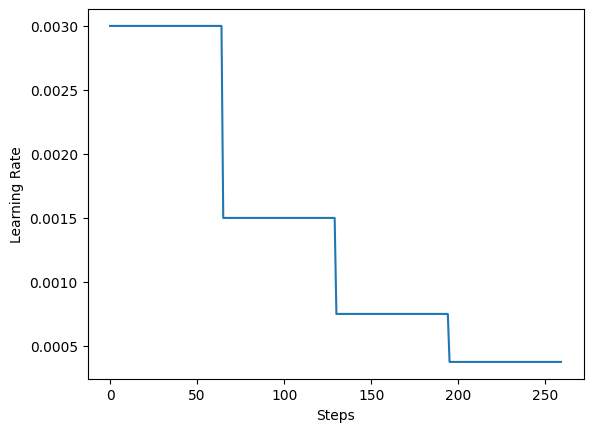

In [22]:
EPOCHS = 20

steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()


In [23]:
def train(epochs):
    segmentation_model = get_shape_segmentation_model(NUM_POINTS, NUM_CLASSES, N_FEATURES, INIT_SIZE, END_SIZE)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = REPO_BASEPATH / "results" / "models" / "pointnet_baseline.weights.h5"
    checkpoint_filepath.parent.mkdir(exist_ok=True, parents=True)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history

In [24]:
segmentation_model, history = train(epochs=EPOCHS)

Epoch 1/20


I0000 00:00:1732451344.618687    3181 service.cc:145] XLA service 0x7f4d000390c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732451344.618744    3181 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2024-11-24 12:29:04.808341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 12:29:05.647978: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6363 - loss: 8.2179

I0000 00:00:1732451357.291635    3181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 947ms/step - accuracy: 0.6836 - loss: 7.6674 - val_accuracy: 0.8734 - val_loss: 6.7656
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8691 - loss: 5.0708 - val_accuracy: 0.8734 - val_loss: 5.4814
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8785 - loss: 4.8691 - val_accuracy: 0.8734 - val_loss: 5.1140
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8665 - loss: 4.7687 - val_accuracy: 0.8734 - val_loss: 4.9892
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8701 - loss: 4.7323 - val_accuracy: 0.8734 - val_loss: 4.9065
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8767 - loss: 4.6995 - val_accuracy: 0.8734 - val_loss: 4.7694
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8735 - loss: 4.6470 - val_accuracy: 0.8734 - val_loss: 4.7089
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8897 - loss: 4.6593 - val_accuracy: 0.8734 - val_loss: 

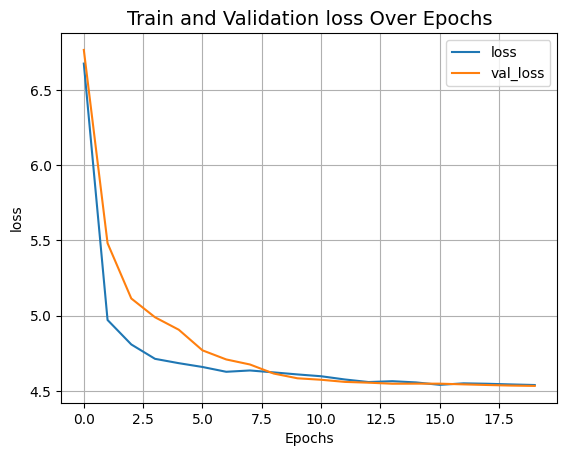

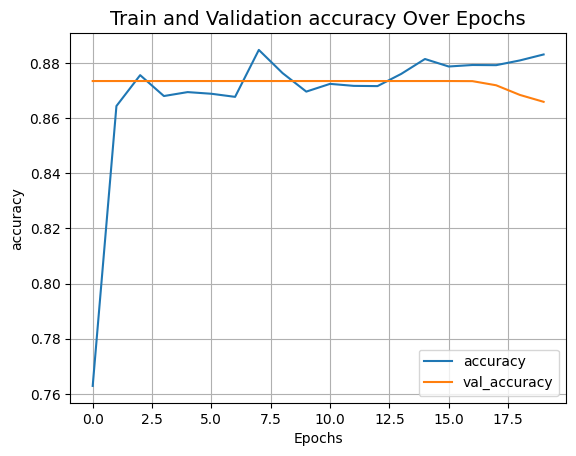

In [25]:
plot_result(history, "loss")
plot_result(history, "accuracy")


### Model debugging

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Validation prediction shape: (16, 800, 2)
Index selected: 13


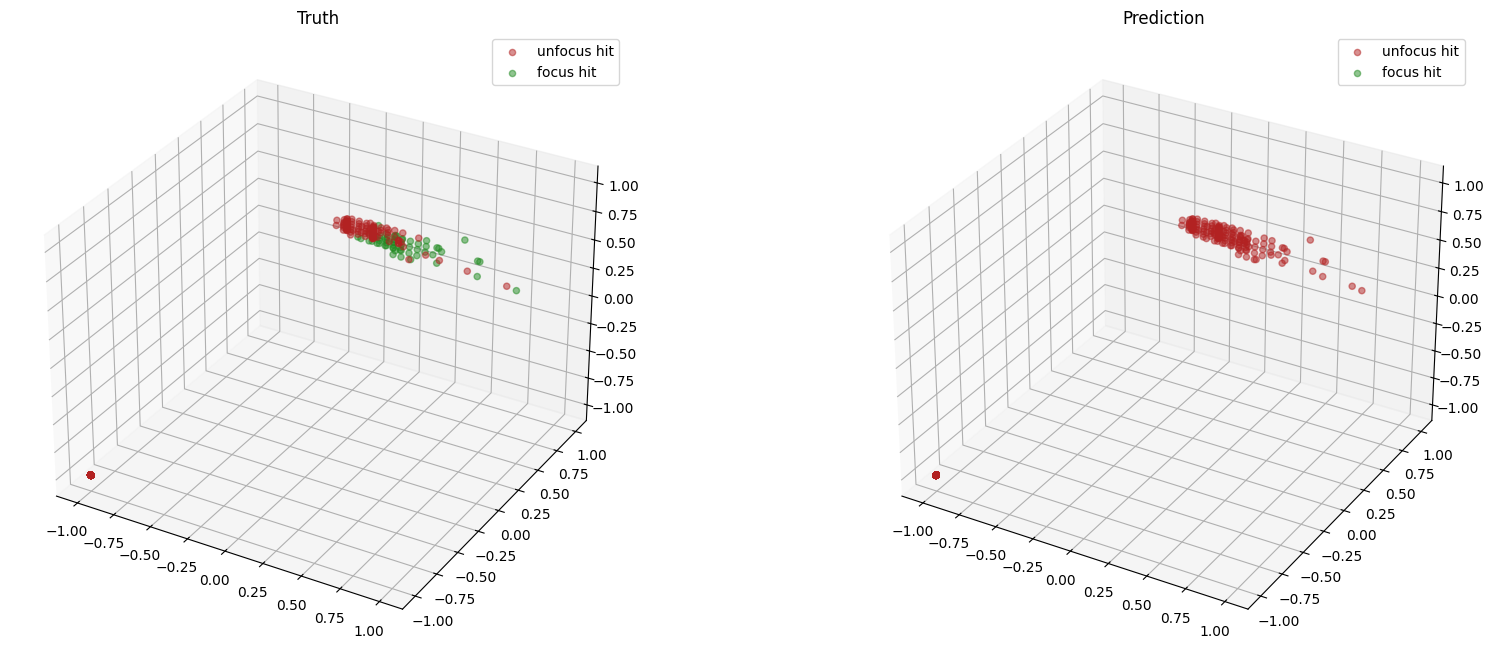

In [29]:
val_predictions = segmentation_model.predict(validation_batch[0])
val_predictions = (val_predictions > 0.5).astype(np.int16)
print(f"Validation prediction shape: {val_predictions.shape}")

class_colors = {0: 'firebrick', 1: 'forestgreen',}

idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")


fig = plt.figure(figsize=(20, 8))  # Double the width compared to single plot
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first plot
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second plot

# Plotting with ground-truth.
panel_left = visualize_prediction(validation_batch[0], validation_batch[1], idx, ax1)
ax1.set_title("Truth")

# Plotting with predictiosn
panel_right = visualize_prediction(validation_batch[0], val_predictions, idx, ax2, LABELS)
ax2.set_title("Prediction")

plt.show()
